In [2]:
from numpy import random 
import numpy as np 
import math
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

from numba import jit

In [3]:
sigma   = 1
L =  32.
dx = 1.0/32
halfL = L/2
#z=1 #exp(mu)

In [4]:
# Some helper functions
@jit
def wrap(particle):
    '''Apply perodic boundary conditions.'''
    if particle >= L:
        particle -= L
    elif particle < 0:
        particle += L
    return particle

In [5]:
@jit
def Vext_cal(x,a,b,c):
    V=0
    return V    

/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


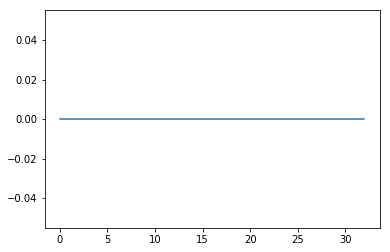

In [6]:
x= np.linspace(0,L,32//dx)
Vext = np.zeros(int(32/dx))
for i in range (int(32/dx)):
    Vext[i]=Vext_cal(i*L/32*dx,1,L/4,3)
plt.plot(x,Vext)


In [7]:
@jit
def distancesq(x1, x2):
    '''Gets the squared distance between two particles, applying the minimum image convention.'''
    # Calculate distances
    Dx = np.abs(x1-x2)
    if Dx > halfL:
        Dx -= L
    return Dx**2

In [8]:
@jit
def energy(particles,exist,epsilon,a,b,c):
    '''Gets the energy of the system'''
    energy = 0.
    
    for i in range(int(L)):
        for j in range(int(L)):
            if(i!=j and exist[i]*exist[j]==1):
                dist = distancesq(particles[i], particles[j])
                energy += 4.*epsilon*((1/dist**6)-(1/dist**3))
                if(dist<1):
                    print("Wrong!!!!")
    energy/=2
    
    for i in range(int(L)):
        if(exist[i]==1):
            energy+=Vext_cal(particles[i],a,b,c)
    
    return energy 

In [9]:
@jit
def particleEnergy(particle,p,exist, particles,epsilon,a,b,c):
    '''Gets the energy of a single particle.'''
    part_energy = 0.
    
    for i in range(int(L)):
        if(i!=p and exist[i]==1):
            dist = distancesq(particle, particles[i])
            if(dist<1):
                return 10**8
            part_energy += 4*epsilon*((1/dist**6)-(1/dist**3))
            
    
    part_energy+=Vext_cal(particle,a,b,c)
    
    return part_energy

In [10]:
# Initialize the simulation box:
@jit
def initial():
    particles = np.zeros(int(L))
    exist = np.zeros(int(L))
    for i in range(int(L)):
        #x_coord = random.uniform(0, L)
        particles[i]=i
        prop = random.uniform(0, 1)
        #if(prop>=0.5):
        #    exist[i]=1
    return particles,exist

In [11]:
@jit
def density_cal(particles,exist):
    n=int(L/dx)
    #dx=L/n
    #print(n,dx)
    rho = np.zeros(int(n),float)
    for i in range(int(L)):
        if(exist[i]==1):
            j=np.around(particles[i]//dx)
            rho[int(j)]+=1
    return rho/dx

@jit
def g_r_cal(particles,exist):
    n=int(L/dx)
    #dx=L/n
    #print(n,dx)
    rho2 = np.zeros(int(n),float)
    for i in range(int(L)):
        for j in range(i+1,int(L)):
            if(exist[i]==1 and exist[j]==1):
                dis=np.around(distancesq(particles[i],particles[j])**0.5/dx)
                rho2[int(dis)]+=1
    return rho2/dx*((np.sum(exist)-1)/(np.sum(exist)))



In [12]:
@jit
def insertion(particles,z,exist,eps,a,b,c):
    for i in range (int(L)):
        if(exist[i]==0):
            particles[i] = random.uniform(0, L)
            ene = particleEnergy(particles[i],i,exist, particles,eps,a,b,c)
            prop = z*L/(np.sum(exist)+1)*np.exp(-ene)
            if(prop>=1):
                exist[i]=1
            elif(prop<1):
                dice = random.uniform(0, 1)
                if(dice<prop):
                    exist[i]=1
            break

@jit                   
def deletion(particles,z,exist,eps,a,b,c):
    M=np.random.randint(1,np.sum(exist)+1)
    cum_exist=np.cumsum(exist)
    for i in range (int(L)):
        if(exist[i]==1 and cum_exist[i]==M):
            ene = -particleEnergy(particles[i],i,exist, particles,eps,a,b,c)
            prop = np.sum(exist)/L/z*np.exp(-ene)
            if(prop>=1):
                exist[i]=0
            elif(prop<1):
                dice = random.uniform(0, 1)
                if(dice<prop):
                    exist[i]=0
            break
            

In [13]:
@jit
def MC_step(particles,z,exist,steps,eps,a,b,c,Print=True):
    for step in range(0, steps):
        prop = np.random.uniform(-0.5, 0.5)
        if(prop>0 and np.sum(exist)<L):
            insertion(particles,z,exist,eps,a,b,c)
        elif(np.sum(exist)>0):
            deletion(particles,z,exist,eps,a,b,c)
        if(step%100000==0 and Print==True):
            print(step,np.sum(exist))
    return particles,energy(particles,exist,eps,a,b,c) 

In [14]:
@jit
def MC_result(seed,z,eps,a,b,c):

    np.random.seed(seed)
    particles,exist = initial()
    "warm up"
    particles, energy = MC_step(particles,z,exist,10000,eps,a,b,c)
    avg_step = 10**5
    rho = density_cal(particles,exist)
    rho2 = g_r_cal(particles,exist)
    energy_avg=0
    N_avg=0
    ene_array = np.zeros(0)
    N_array = np.zeros(0)
    ene_array=np.append(ene_array,energy)
    N_array=np.append(N_array,np.sum(exist))
    for i in range(avg_step-1):
        np.random.seed(i)
        particles, ene = MC_step(particles,z,exist,1000,eps,a,b,c,Print=False)
        ene_array=np.append(ene_array,ene)
        N_array=np.append(N_array,np.sum(exist))
        rho += density_cal(particles,exist )
        rho2 += g_r_cal(particles,exist)
        if(i%10000==0):
            print(i,ene,np.sum(exist))
    rho=rho/avg_step
    rho2=rho2/avg_step
    print("energy_avg",np.sum(ene_array)/len(ene_array),
          np.sum(N_array)/len(N_array)/L)
    return rho,rho2, particles,ene_array,N_array


def density_result(seed,z,eps):
    """
    density = random.uniform(0.3,0.5)
    a=random.uniform(1,3)
    b=random.uniform(0,1)
    c=random.uniform(1,L/8)
    """
    a=0
    b=0
    c=0
    rho,rho2,particles,energy,N_array = MC_result(seed,z,eps,a,b,c)
    return rho,rho2,particles,energy,N_array

In [19]:
def c2_sim(z,eps):
    rho,rho2,particles,energy_array,N_array=density_result(123,z,eps)
    rho_avg = np.mean(rho)
    gr=rho2*dx*2
    n=int(L//dx)
    gr=(gr+np.roll(np.flip(gr,axis=0),1))
    gr /=np.mean(gr[n//2-5:n//2+5])
    h2 = (gr - 1)
    h2_fft = np.fft.rfft((h2))*dx
    c2 = np.fft.irfft(h2_fft/(1+rho_avg*h2_fft))/dx
    return c2,rho_avg

In [21]:
c2,rho_avg=c2_sim(1,1)

0 0.0
0 -4.919206932122682 14.0
10000 -4.963227477662929 15.0
20000 -8.251881694070024 18.0
30000 -6.625649272778982 14.0
40000 -6.474937016786183 17.0
50000 -7.080427946397301 15.0
60000 -8.396545060314365 18.0
70000 -6.55064335462661 15.0
80000 -5.580671537188196 16.0
90000 -4.104627145923676 14.0
energy_avg -5.483030476340066 0.465329375


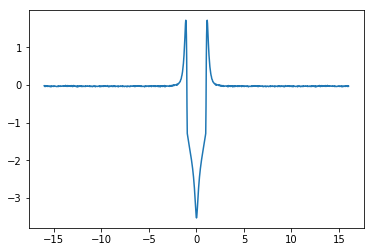

In [26]:
plt.plot(x-L/2,np.roll(c2,int(L/dx//2)))

In [28]:
tmp = [1,1.5,1.8,1.85,2]
for i in range (len(tmp)):
    z=tmp[i]
    eps=tmp[i]
    print("z=",z,"eps=",eps)
    c2,rho_avg=c2_sim(z,eps)
    np.savetxt("c2_z_"+str(z)+"_eps_"+str(eps)+"_rho_avg_"+str(rho_avg)[0:4],np.stack((x-L/2,np.roll(c2,int(L/dx//2)))))

z= 1 eps= 1
0 0.0
0 -3.8631126436277783 12.0
10000 -9.591895342208419 20.0
20000 -10.143375618855252 19.0
30000 -6.257900860612089 16.0
40000 -3.9067570713175686 14.0
50000 -5.327163662978249 13.0
60000 -0.514328762500071 7.0
70000 -7.981940323122411 17.0
80000 -10.760133794997804 18.0
90000 -2.3389430963005067 11.0
energy_avg -5.488406130260669 0.465405
z= 1.5 eps= 1.5
0 0.0
0 -17.021486440749175 20.0
10000 -14.6255448262484 21.0
20000 -14.454439520298324 21.0
30000 -17.761455674931415 23.0
40000 -15.437508073604791 20.0
50000 -10.867951918798383 16.0
60000 -20.166473943235264 22.0
70000 -14.58056723286873 19.0
80000 -13.658495352768558 19.0
90000 -17.874924205380328 22.0
energy_avg -16.150111231908248 0.6189084375
z= 1.8 eps= 1.8
0 1.0
0 -31.875362086608316 25.0
10000 -28.770675711568494 24.0
20000 -17.96005920543901 19.0
30000 -26.581418611085386 23.0
40000 -40.92623180098747 27.0
50000 -22.99790964966433 21.0
60000 -15.221281459644437 20.0
70000 -26.94978043744869 22.0
80000 -18.92

In [ ]:
plt.plot(c2)

In [ ]:
rho_avg

In [ ]:
np.stack((x,c2))

In [ ]:
str(rho_avg)[0:4]

In [ ]:
np.savetxt("c2_z_"+str(z)+"_eps_"+str(eps)+"_rho_avg_"+str(rho_avg)[0:4],np.stack((x,c2)))

In [48]:
def f2 (x,mu):
    c1_FMT = x/(1-x)-np.log(1-x)
    return (np.log(x)+c1_FMT-mu)**2

def cal_rho0(mu):
    
    c1=0  
    rho_guess = np.zeros(3)
    res = np.zeros(3)
    interval = 0.01

    for i in range(3):
        rho_guess[i] = 0.3+interval*i
        
    for iteration in range (10000):
        for i in range(3):
            res[i] = f2(rho_guess[i],mu)
        if(res[0]>res[1] and res[2]>res[1]):
            interval/=2
            rho_guess[0]=rho_guess[1]-interval
            rho_guess[2]=rho_guess[1]+interval
        elif(res[1]>res[0] and res[2]>res[0]):
            temp = rho_guess[0]
            rho_guess[0]=temp-interval
            rho_guess[1]=temp
            rho_guess[2]=temp+interval
        else:
            temp = rho_guess[2]
            rho_guess[0]=temp-interval
            rho_guess[1]=temp
            rho_guess[2]=temp+interval
            
        if(rho_guess[0]<0 or rho_guess[2]>1):
            break
        if(interval<10**-8):
            #print(rho_guess[1],iteration)
            break        
    
    temp=rho_guess[1]
    if(temp<=0):
        return 0.1
    elif(temp>1):
        return 0.9
    else:
        return rho_guess[1]


def c2_homo(r,rho0):
    if(np.abs(r)>1):
        return 0
    eta=rho0
    return -(1-r*eta)/(1-eta)**2


mu = np.log(z)
rho0 = cal_rho0(mu)
print(mu,rho0)
c2_ref = np.zeros(len(x))
for i in range (len(x)//2+1):
    r=i*dx
    c2_ref[i]=c2_homo(x[i],rho0)
    if(r>=1):
        c2_ref[i]+=-4*eps*(r**(-12)-r**(-6))
    


0.6931471805599453 0.46021966934204106


(0, 3)

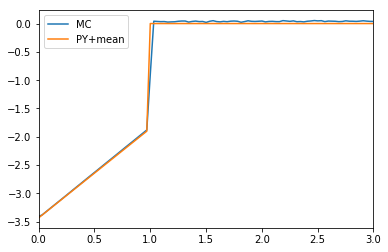

In [49]:
plt.plot(x,c2,label="MC")
plt.plot(x,c2_ref,label="PY+mean")
plt.legend()
plt.xlim(0,3)

In [39]:
x

array([0.00000000e+00, 3.12805474e-02, 6.25610948e-02, ...,
       3.19374389e+01, 3.19687195e+01, 3.20000000e+01])

In [33]:
np.savetxt("c2_PY_mean.dat",c2_ref)
np.savetxt("c2_MC.dat",c2)


In [23]:
@jit
def w_FMT(eps):
    #d=cal_eff_diameter (eps)
    R = 0.5
    k=np.linspace(0,N//2,N//2+1)*2*np.pi/L
    w0=2*np.cos(k*R)/2
    k[0]=1 #keep notebook shutup
    w1=2*np.sin(k*R)/k
    w1[0]=2*R
    return w0,w1;

@jit
def cal_n0(rho,w0):
    return np.fft.irfft(np.fft.rfft(rho)*w0)

@jit
def cal_n1(rho,w1):
    return np.fft.irfft(np.fft.rfft(rho)*w1)

@jit
def cal_c1_FMT(rho,eps):
    w0,w1 = w_FMT(eps)
    n0=cal_n0(rho,w0)
    n1=cal_n1(rho,w1)
    F0=-np.log(1-n1)
    F1=n0/(1-n1)
    return cal_n0(F0,w0)+cal_n1(F1,w1)

@jit
def cal_Utail (Dx,epsilon):
    Dx = np.abs(Dx)
    if Dx>L/2:
        Dx= np.abs(Dx)-L
        
    if np.abs(Dx)<=1:
        return 0
    
    else:
        Dx2=Dx**2
        return 4*epsilon*(1/Dx2**6-1/Dx2**3)

@jit
def cal_Ftail_drho(rho,epsilon):
    Utail = np.zeros(N)
    for i in range (N):
        Utail[i]=cal_Utail(i*dx,epsilon)        
    Ftail = np.zeros(N)
    
    for i in range (N):
        for j in range (N):
            Ftail[i]+=Utail[np.abs(i-j)]*rho[j]*dx
    return Ftail

@jit
def cal_c1_mean(rho,epsilon):
    Ftail=cal_Ftail_drho(rho,epsilon)
    return cal_c1_FMT(rho,epsilon)+Ftail

@jit
def update_rho_mean(rho,c1,Vext,mu,alpha=0.1,wall=True):
    #mu=np.log(np.sum(np.sum(rho)/np.sum(np.exp(-c1-Vext))))
    rho_new =np.exp(mu-c1-Vext)
    if(wall):
        rho_new[0:int(1.0/dx)]=0
    rho = (1-alpha)*rho+alpha*rho_new
    err = np.sum((rho_new-rho)**2)
    return rho,err


In [24]:
N = int(L/dx)
mu = np.log(z)
rho_Mean=np.full(N,0.5)
rho_Mean=np.zeros(N)
Vext=np.zeros(N)

alpha = 0.1
thread = 10**-6
error_pre = pow(10,6)
error=0
for iteration in range(1000):
    rho_Mean_pre = np.copy(rho_Mean)
    c1=cal_c1_mean(rho_Mean,eps)
    rho_Mean,error= update_rho_mean(
        rho_Mean,c1,Vext,mu,alpha,False)

    if(error>error_pre):
        alpha = alpha/2
        rho_Mean = np.copy(rho_Mean_pre)
    else:    
        error_pre = error

    if(error<thread or alpha<thread):
        print(iteration," error=",error, "alpha=", alpha)
        break    

    if(iteration%10==0):
        print(iteration," error=",error, "alpha=", alpha)

rhol_Mean = np.mean(rho_Mean)
alpha = 0.1
thread = 10**-6
error_pre = pow(10,6)
error=0
for iteration in range(1000):
    rho_Mean_pre = np.copy(rho_Mean)
    c1=cal_c1_mean(rho_Mean,eps)
    rho_Mean,error= update_rho_mean(
        rho_Mean,c1,Vext,mu)

    if(error>error_pre):
        alpha = alpha/2
        rho_Mean = np.copy(rho_Mean_pre)
    else:    
        error_pre = error

    if(error<thread or alpha<thread):
        print(iteration," error=",error, "alpha=", alpha)
        break    

    if(iteration%10==0):
        print(iteration," error=",error, "alpha=", alpha)
        


0  error= 1866.2399999999916 alpha= 0.1
10  error= 0.6355095840171281 alpha= 0.1
20  error= 0.000524638979416854 alpha= 0.1
29  error= 9.018885384921173e-07 alpha= 0.1
0  error= 4.584738062360212 alpha= 0.1
10  error= 0.7677320229114861 alpha= 0.1
20  error= 0.13460929439415056 alpha= 0.1
30  error= 0.022772828487197375 alpha= 0.1
40  error= 0.003809355408738273 alpha= 0.1
50  error= 0.0006373469699096966 alpha= 0.1
60  error= 0.00010736797112552203 alpha= 0.1
70  error= 1.8289058943188513e-05 alpha= 0.1
80  error= 3.158015899507378e-06 alpha= 0.1
87  error= 9.316966983962184e-07 alpha= 0.1


In [25]:
invc = np.fft.rfft((c2_ref))*dx
gr_mean = np.fft.irfft(invc/(1-rhol_Mean*invc))/dx+1


(0, 5)

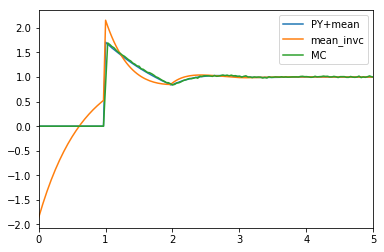

In [26]:
plt.plot(x,rho_Mean/rhol_Mean,label="PY+mean")
plt.plot(x,gr_mean,label="mean_invc")
plt.plot(x,gr,label="MC")
plt.legend()
plt.xlim(0,5)

In [27]:
np.savetxt("gr_PY_mean.dat",rho_Mean/rhol_Mean)
np.savetxt("gr_MC.dat",gr)
